# Movilizate Salud

## ---------Inicializacion (One Time Run Only)---------

In [1]:
#Importando librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import pybingmaps
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import timeit
from sklearn.model_selection import train_test_split
from sklearn import linear_model

#Key API Maps
bing = pybingmaps.Bing('AizoCiuRwxjT9SjxftwCItVoRXI2v0V3UnLTKSebigC5GUW5NklrIZpL5jRANFuJ')

#Porcentajes de Preferencia, dados por el usuario. En esta etapa fueron definidos por el equipo
pref_Tiempo = 0.3
pref_Distancia = 0.1
pref_Consultorio = 0.1
pref_Medicos = 0.2
pref_Ocupacion =  0.3

In [2]:
#Importando los datos y convirtiendolo en un dataframe
df_Hospitals = pd.read_excel("./Master_Dataset_AI_Saturday.xlsx")

In [3]:
# Juntando las coordenadas de los hospitales en un solo dataframe que es utilizado por el algoritmo de Nearest Neighbors
df_LatitudHospitals = pd.DataFrame(df_Hospitals['LATITUD'])
df_LongitudHospitals = pd.DataFrame(df_Hospitals['LONGITUD'])
df_coordenadasHospitals = df_LatitudHospitals.join(df_LongitudHospitals)

Ev_hospitales = df_Hospitals

# Percentrank(Evaluacion) de los parametros Total de Consultorios y Medicos Generales (Variables Estaticas)

Ev_hospitales['Ev_Consultorios'] = Ev_hospitales.reset_index() \
                                [['TOTAL DE CONSULTORIOS']] \
                                .apply(lambda x: (x.rank(method='dense') - 1) / (x.nunique() - 1) ) \
                                .values

Ev_hospitales['Ev_Medicos'] = Ev_hospitales.reset_index() \
                            [['TOTAL MEDICOS GENERALES Y ESPECIALISTAS']] \
                            .apply(lambda x: (x.rank(method='dense') - 1) / (x.nunique() - 1) ) \
                            .values

# Se añade Calificacion al dataframe de evaluación la cual suma de estos dos parametros multiplicado por
#su factor de preferencia
Ev_hospitales["Calificacion"] =( (Ev_hospitales['Ev_Consultorios']* pref_Consultorio)
                                                +(Ev_hospitales['Ev_Medicos']* pref_Medicos))

In [4]:
Ev_hospitales.tail()

,AÑO,CLUES,CLAVE INSTITUCION,CLAVE MUNICIPIO,LATITUD,LONGITUD,DISTANCIA,TIEMPO TRANSLADO,NOMBRE DE LA UNIDAD,TOTAL DE CONSULTORIOS,...,TOTAL CAMAS EN OTRAS AREAS (NO CONSIDERA HOSPITALIZACIÓN),TOTAL MEDICOS GENERALES Y ESPECIALISTAS,TOTAL DE ENFERMERAS EN CONTACTO CON EL PACIENTE,TOTAL DE URGENCIAS(AFECCIONES),EGRESOS HOSPITALARIOS,TOTAL CONSULTA EXTERNA ADULTOS Y PEDIATRIA 1RA VEZ Y SUBSECUENTE,NUMEROS DE PACIENTES POR HOSPITAL,Ev_Consultorios,Ev_Medicos,Calificacion
167,2018,JCSSA013260,SSA,98,20.415500,-103.666000,44.52,89.04,UNIDAD MÓVIL DE ATENCIÓN A LA SALUD DE LA MUJE...,1,...,0,1,1,NaN,NaN,NaN,NaN,0.032258,0.022727,0.007771
168,2018,JCSSA013255,SSA,101,20.632400,-103.252000,1.37,2.74,UNIDAD MÓVIL DE ATENCIÓN A LA SALUD DE LA MUJE...,1,...,0,0,0,NaN,NaN,NaN,NaN,0.032258,0.000000,0.003226
169,2018,JCSSA013214,SSA,120,20.683800,-103.451000,7.48,14.96,UNIDAD MÓVIL DE ATENCIÓN A LA SALUD DE LA MUJE...,1,...,0,0,0,NaN,NaN,NaN,NaN,0.032258,0.000000,0.003226
170,2018,JCSSA013663,SSA,39,20.679007,-103.342022,0.63,1.26,UNIDAD MÓVIL DE COLPOSCOPIA,1,...,0,1,0,NaN,NaN,NaN,NaN,0.032258,0.022727,0.007771
171,2018,JCSSA007416,SSA,120,20.798700,-103.487000,13.20,26.40,UNIDAD MÓVIL TESISTÁN,1,...,0,0,0,NaN,NaN,NaN,NaN,0.032258,0.000000,0.003226


## ---------Training Inicial (One Time Run Only)---------

#### Nearest Neighbors

In [5]:
#DOCUMENTACION K NEAREST NEIGHBORS
#https://scikit-learn.org/stable/modules/neighbors.html
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

tic=timeit.default_timer()
#Solamente se seleccionaran los 10 neighbors mas cercanos
nbrs = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(df_coordenadasHospitals)
toc=timeit.default_timer()
print("Tiempo Nearest Neighbors:",toc-tic)

Tiempo Nearest Neighbors: 0.0038626239999999257


#### Bayesian Ridge Regression

In [6]:
#DOCUMENTACION BAYESIAN RIDGE REGRESSION
#https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression

In [7]:
X = Ev_hospitales[['TOTAL DE CONSULTORIOS','TOTAL MEDICOS GENERALES Y ESPECIALISTAS']]
y = Ev_hospitales['Calificacion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=417)

In [8]:
tic=timeit.default_timer()
regr = linear_model.BayesianRidge()
reg = regr.fit(X_train, y_train)
y_pred = reg.predict(X_test)
toc=timeit.default_timer()
print("Time Bayesian Ridge Regression",toc-tic)

Time Bayesian Ridge Regression 0.2376521870000019


In [9]:
#### METRICS

y_pred = pd.Series(y_pred)
df_y_pred = pd.DataFrame(y_pred)
df_y_test = pd.DataFrame(y_test)
df_y_test = df_y_test.reset_index()
df_y_test = df_y_test.drop(['index'], axis=1)

df_error = df_y_test.join(df_y_pred)
df_error = df_error.rename({"Calificacion": "y_test", 0: "y_pred"}, axis='columns')
for i in df_error.index:
    df_error.at[i, '% Error']  = abs(((df_error.iat[i,0] - df_error.iat[i,1])) / df_error.iat[i,0])*100
    
arr_y_test = df_error[["y_test"]].to_numpy()
arr_y_pred = df_error[["y_pred"]].to_numpy()

#Variance Score
variance_score = explained_variance_score(arr_y_test, arr_y_pred)
print("Variance Score:",variance_score)

#Mean Absolute Error
MAE = mean_absolute_error(arr_y_test, arr_y_pred)
print("Mean Absolute Error:",MAE)

#Root Mean Squared Error
RSME = mean_squared_error(arr_y_test, arr_y_pred, squared=False)
print("Root Mean Squared Error",RSME)

#R2
R2= r2_score(arr_y_test, arr_y_pred)
print("R2",R2)


Variance Score: 0.9319793338810748
Mean Absolute Error: 0.013237854269503531
Root Mean Squared Error 0.018178524831451007
R2 0.9311509376469557


## *Inputs

In [10]:
#Inicializacion de variables de tu posicion
my_latitude =20.677041
my_longuitud =-103.347745
my_location = (my_latitude, my_longuitud)
df_my_location = pd.DataFrame({'Latitud': [my_latitude],'Longuitud': [my_longuitud]})

## ---------Ejecucion (Llamar cada vez que se quiera recalcular las opciones)---------

#### K Nearest Neighbors

In [11]:
#Entrenamiento no supervisado del algoritmo K Nearest Neighbor
distances, indices = nbrs.kneighbors(df_my_location)
df_Out = pd.DataFrame(indices)
df_Out = df_Out.T
df_Out = df_Out.rename({0: "Indices"}, axis='columns')

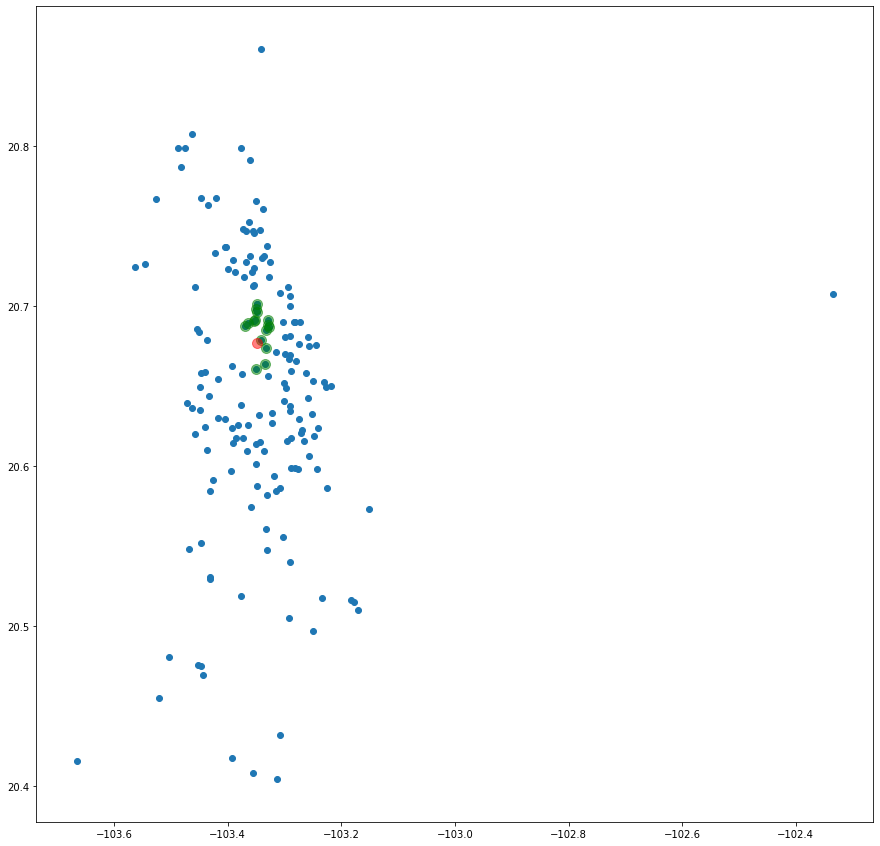

In [12]:
#Visualizacion (Este Paso solamente es para mostrar los hospitales, cuales fueron los que estan mas
#cercanos - verdes, y el punto en el que te encuentras actualmente -rojo) Este seccion se puede comentar

vissual = df_Out
for i in vissual.index:
    indice = vissual.iat[i,0]
    vissual.at[i, 'Latitud'] = df_coordenadasHospitals.iat[indice,0]
    vissual.at[i, 'Longuitud'] = df_coordenadasHospitals.iat[indice,1]

vissual = vissual.drop(['Indices'], axis=1)
array_indices = vissual.to_numpy()

plt.subplots(figsize=(15, 15))
plt.scatter(df_Hospitals['LONGITUD'], df_Hospitals['LATITUD'], cmap='viridis')
plt.scatter(array_indices[:, 1], array_indices[:, 0], c='green', s=100, alpha=0.5);
plt.scatter(my_longuitud, my_latitude, c='red', s=100, alpha=0.5);

In [13]:
# Se empieza crear el dataframe final el cual va a contener toda la informacion de salida
# La API añade los tiempos de traslado y distancia al dataframe
tic=timeit.default_timer()
for i in df_Out.index:
    indice = df_Out.iat[i,0]
    df_Out.at[i, 'NOMBRE DE LA UNIDAD'] = df_Hospitals.iat[indice,8]   
    df_Out.at[i, 'TOTAL DE CONSULTORIOS'] = df_Hospitals.iat[indice,9]
    df_Out.at[i, 'TOTAL MEDICOS GENERALES Y ESPECIALISTAS'] = df_Hospitals.iat[indice,12]   
    hospital_location = (df_Hospitals.iat[indice,4], df_Hospitals.iat[indice,5])
    df_Out.at[i, 'Tiempo_Estimado(seg)'] = bing.travelTime(my_location, hospital_location )
    df_Out.at[i, 'Distancia_Estimada(km)'] = bing.travelDistance(my_location, hospital_location)

toc=timeit.default_timer()

#Se hace la prediccion de las calificaciones mediante el algoritmo de Bayesian Ridge Regressor
pred = df_Out[['TOTAL DE CONSULTORIOS','TOTAL MEDICOS GENERALES Y ESPECIALISTAS']]
df_Out["Calificacion"] = reg.predict(pred)

print("Tiempo API Bing:",toc-tic)

Tiempo API Bing: 6.411645424


In [14]:
df_Out

,Indices,Latitud,Longuitud,NOMBRE DE LA UNIDAD,TOTAL DE CONSULTORIOS,TOTAL MEDICOS GENERALES Y ESPECIALISTAS,Tiempo_Estimado(seg),Distancia_Estimada(km),Calificacion
0,170,20.679007,-103.342022,UNIDAD MÓVIL DE COLPOSCOPIA,1.0,1.0,226.0,0.783,0.019030
1,37,20.690800,-103.353000,CENTRO DE SALUD GUADALAJARA 3,13.0,26.0,430.0,2.067,0.111400
2,69,20.673800,-103.333000,CENTRO DE SALUD N°1,9.0,15.0,461.0,2.286,0.074459
3,157,20.691573,-103.352040,UMF 79 GUADALAJARA,10.0,15.0,515.0,2.765,0.077351
4,139,20.660603,-103.350850,UMF 1 GUADALAJARA,26.0,51.0,356.0,1.920,0.206661
5,144,20.685355,-103.331897,UMF 3 GUADALAJARA,36.0,84.0,574.0,2.202,0.311699
6,149,20.664053,-103.334850,UMF 49 GUADALAJARA,10.0,20.0,417.0,2.600,0.088884
7,120,20.696100,-103.348000,CENTRO DENTAL INFANTIL DE ESPECIALIDADES,5.0,17.0,438.0,2.185,0.067504
8,143,20.689246,-103.364809,UMF 2 GUADALAJARA,37.0,73.0,657.0,3.073,0.289219
9,150,20.698207,-103.349474,UMF 51 GUADALAJARA,33.0,60.0,527.0,2.742,0.247665


In [15]:
# Haciendo el PercentRank de las variables que no son estaticas sobre el data frame ya filtrado de los nearest neighbors

df_Out['Ev_Tiempo'] = df_Out.reset_index() \
                        [['Tiempo_Estimado(seg)']] \
                        .apply(lambda x: (x.rank(method='dense') - 1) / (x.nunique() - 1) ) \
                        .values

df_Out['Ev_Distancia'] = df_Out.reset_index() \
                            [['Distancia_Estimada(km)']] \
                            .apply(lambda x: (x.rank(method='dense') - 1) / (x.nunique() - 1) ) \
                            .values

# Aquellos parametros que sean los menores seran los que tengan la maxima calificacion
df_Out["Ev_Tiempo"] = (-1 * df_Out["Ev_Tiempo"])+1
df_Out["Ev_Distancia"] = (-1 * df_Out["Ev_Distancia"])+1

# Sumando todas las calificaciones y multiplicandolas por su factor de preferencia para obtener la calificacion final
for i in df_Out.index:
    df_Out["Calificacion_Final"] =( df_Out['Ev_Tiempo'] * pref_Tiempo
                          +df_Out['Ev_Distancia']* pref_Distancia
                          +df_Out['Calificacion'])

#Haciendo el rankeo final con las calificaciones finales obtenidas
df_Out["Ranking"] = df_Out['Calificacion_Final'].rank(method='dense', ascending = False)


In [16]:
df_Out

,Indices,Latitud,Longuitud,NOMBRE DE LA UNIDAD,TOTAL DE CONSULTORIOS,TOTAL MEDICOS GENERALES Y ESPECIALISTAS,Tiempo_Estimado(seg),Distancia_Estimada(km),Calificacion,Ev_Tiempo,Ev_Distancia,Calificacion_Final,Ranking
0,170,20.679007,-103.342022,UNIDAD MÓVIL DE COLPOSCOPIA,1.0,1.0,226.0,0.783,0.019030,1.000000,1.000000,0.419030,5.0
1,37,20.690800,-103.353000,CENTRO DE SALUD GUADALAJARA 3,13.0,26.0,430.0,2.067,0.111400,0.785714,0.857143,0.432828,4.0
2,69,20.673800,-103.333000,CENTRO DE SALUD N°1,9.0,15.0,461.0,2.286,0.074459,0.642857,0.642857,0.331602,9.0
3,157,20.691573,-103.352040,UMF 79 GUADALAJARA,10.0,15.0,515.0,2.765,0.077351,0.571429,0.428571,0.291637,10.0
4,139,20.660603,-103.350850,UMF 1 GUADALAJARA,26.0,51.0,356.0,1.920,0.206661,0.928571,0.928571,0.578090,1.0
5,144,20.685355,-103.331897,UMF 3 GUADALAJARA,36.0,84.0,574.0,2.202,0.311699,0.428571,0.714286,0.511699,2.0
6,149,20.664053,-103.334850,UMF 49 GUADALAJARA,10.0,20.0,417.0,2.600,0.088884,0.857143,0.571429,0.403170,6.0
7,120,20.696100,-103.348000,CENTRO DENTAL INFANTIL DE ESPECIALIDADES,5.0,17.0,438.0,2.185,0.067504,0.714286,0.785714,0.360361,8.0
8,143,20.689246,-103.364809,UMF 2 GUADALAJARA,37.0,73.0,657.0,3.073,0.289219,0.285714,0.214286,0.396362,7.0
9,150,20.698207,-103.349474,UMF 51 GUADALAJARA,33.0,60.0,527.0,2.742,0.247665,0.500000,0.500000,0.447665,3.0
